<h1 align=center><font size = 5>Capstone Project - Coffee shops in Paris</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download and Explore Dataset</a>

2. <a href="#item2">Analyze Each Borough</a>

3. <a href="#item3">Cluster Coffee shop</a>

4. <a href="#item4">Examine Clusters</a>    
</font>
</div>

Download and import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [2]:
#pip install lxml html5lib beautifulsoup4

## 1. Download and Explore Datasets

Define my foursquare ID and secret

In [3]:
CLIENT_ID = 'FE3KQCZ4IZOGG2H5XEP4UFT1WNG4O1EDX2ZVVMA2WBNHQS5J' # my Foursquare ID
CLIENT_SECRET = '2Q1I0GNDVZSSVR5R3XJHVJPCTVKDIZAHZXPXK4E0OBCLMERR' # my Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FE3KQCZ4IZOGG2H5XEP4UFT1WNG4O1EDX2ZVVMA2WBNHQS5J
CLIENT_SECRET:2Q1I0GNDVZSSVR5R3XJHVJPCTVKDIZAHZXPXK4E0OBCLMERR


In [4]:
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

Get the geographic informations of Paris

In [5]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


In [6]:
search_query = "Coffee"
radius = 50000
LIMIT = 200

Let's create a function to get nearby coffee shop to all the boroughs in Paris

In [7]:
def getNearbyCoffee(latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
            
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        latitude, 
        longitude, 
        VERSION, 
        search_query, 
        radius, 
        LIMIT)
            
        # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # return only relevant information for each nearby venue
    for v in results:
        if 'postalCode' in v['venue']['location'] and 'city' in v['venue']['location']: 
            venues_list.append([(
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],
                    v['venue']['location']['postalCode'], 
                    v['venue']['location']['city'],
                    v['venue']['location']['address']) ])
            

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Coffee shop', 
                  'Coffee Latitude', 
                  'Coffee Longitude', 
                  'Postal Code',
                  'City',
                  'Address']
    
    return(nearby_venues)

Let's run the above function to create a new dataframe called paris_coffee

In [8]:
paris_coffee = getNearbyCoffee(latitude, longitude, radius, LIMIT)

In [9]:
paris_coffee

,Coffee shop,Coffee Latitude,Coffee Longitude,Postal Code,City,Address
0,Laïzé 來座 (Laïzé),48.863077,2.355073,75003,Paris,19 rue de Montmorency
1,Partisan,48.864754,2.353069,75003,Paris,36 rue de Turbigo
2,Comme à Lisbonne,48.856767,2.356462,75004,Paris,37 rue du Roi de Sicile
3,Dreamin' Man,48.865290,2.366486,75011,Paris,140 rue Amelot
4,Holybelly 5,48.871050,2.359804,75010,Paris,5 rue Lucien Sampaix
...,...,...,...,...,...,...
93,% Arabica,48.854235,2.324839,75007,Paris,53-57 rue de Grenelle
94,The Beans on Fire,48.861511,2.378452,75011,Paris,7 rue du Général Blaise
95,L'Avenue,48.867257,2.306277,75008,Paris,41 avenue Montaigne
96,Café A,48.875236,2.360022,75010,Paris,148 rue du Faubourg Saint-Martin


We got a dataset that contains 98 rows and 6 columns with informations on each coffee.

Now, let's create a dataframe with average commercial rent price by m2 by borough called df_rentPrice.

In [10]:
df_rentPrice = pd.read_csv("Prix_loyer_com.csv")

print(len(df_rentPrice))

20


I renamed one column because it's french and I translate this name in english

In [11]:
df_rentPrice.rename(columns={'prix moyen loyer commercial au m2': 'Average commercial rental price by m2'}, inplace=True)

Let's divide each price by 12 because in the csv, the prices are by year and I think that it's more clearly to have price by month.

In [12]:
df_rentPrice[["Average commercial rental price by m2"]] = df_rentPrice.iloc[:,1:2]/12
df_rentPrice

,Postal Code,Average commercial rental price by m2
0,75001,60.666667
1,75002,49.750000
2,75003,45.583333
3,75004,62.916667
4,75005,46.250000
5,75006,67.333333
6,75007,48.500000
7,75008,75.000000
8,75009,45.833333
9,75010,33.333333


In [13]:
df_rentPrice['Postal Code'] = df_rentPrice['Postal Code'].astype(str)

Let's change the index of the dataframe df_rentPrice to create a barplot which shows the average commercial rental price by borough 

In [14]:
df_rent = df_rentPrice.set_index("Postal Code")
df_rent

,Average commercial rental price by m2
Postal Code,
75001,60.666667
75002,49.750000
75003,45.583333
75004,62.916667
75005,46.250000
75006,67.333333
75007,48.500000
75008,75.000000
75009,45.833333


Let's create the barplot

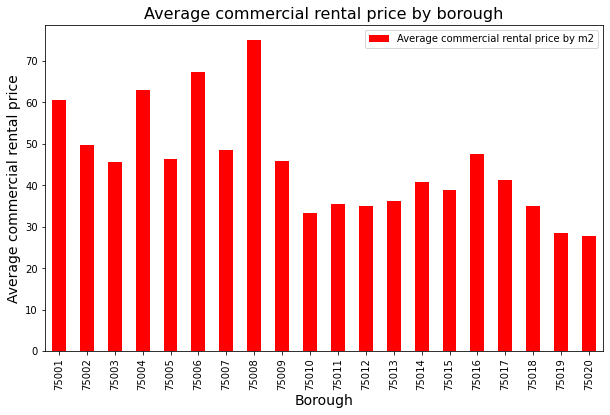

In [15]:
df_rent.plot(kind='bar', figsize=(10,6), color='red')
plt.xlabel('Borough', fontsize=14) # add to x-label to the plot
plt.ylabel('Average commercial rental price', fontsize=14) # add y-label to the plot
plt.title('Average commercial rental price by borough', fontsize=16) # add title to the plot

plt.show()

We merge the two dataframe paris_coffee and df_rentPrice to add the column "average commercial rent price by m2" depending on the postal code of the coffee

In [16]:
merged_inner = pd.merge(left=paris_coffee, right=df_rentPrice, left_on='Postal Code', right_on='Postal Code')

In [17]:
merged_inner

,Coffee shop,Coffee Latitude,Coffee Longitude,Postal Code,City,Address,Average commercial rental price by m2
0,Laïzé 來座 (Laïzé),48.863077,2.355073,75003,Paris,19 rue de Montmorency,45.583333
1,Partisan,48.864754,2.353069,75003,Paris,36 rue de Turbigo,45.583333
2,Terres de Café,48.860580,2.355482,75003,Paris,14 rue Rambuteau,45.583333
3,Lily of the Valley,48.865221,2.361990,75003,Paris,12 rue Dupetit-Thouars,45.583333
4,Fringe,48.862612,2.364752,75003,Paris,106 rue de Turenne,45.583333
...,...,...,...,...,...,...,...
93,Carette,48.863589,2.287205,75016,Paris,4 place du Trocadéro,47.666667
94,O Coffeeshop,48.849090,2.291148,75015,Paris,23 rue de Lourmel,38.833333
95,DOSE – Dealer de Café,48.887078,2.317797,75017,Paris,82 place du Docteur Félix Lobligeois,41.250000
96,Kaffeehaus,48.878941,2.296572,75017,Paris,11 rue Poncelet,41.250000


Now, let's count the number of coffee with recommendations by borough and sort values by ascending order

In [18]:
dfcount = merged_inner.groupby('Postal Code').count().sort_values(by = 'Coffee shop')
dfcount = dfcount[["Coffee shop"]]
dfcount = dfcount.reset_index()
dfcount["Postal Code"] = dfcount["Postal Code"].astype(int)
dfcount

,Postal Code,Coffee shop
0,75020,1
1,75016,1
2,75015,1
3,75014,1
4,75017,2
5,75019,3
6,75018,4
7,75006,4
8,75002,6
9,75007,6


Then, I added the column "average commercial rental price by m2" to the dataframe dfcount. So, we got the number of coffee shop and the rental price for each borough in a dataframe named merged_innerr.

In [19]:
df_rentPrice["Postal Code"] = df_rentPrice["Postal Code"].astype(int)
merged_innerr = pd.merge(left=dfcount, right=df_rentPrice, left_on='Postal Code', right_on='Postal Code')

In [20]:
merged_innerr

,Postal Code,Coffee shop,Average commercial rental price by m2
0,75020,1,27.833333
1,75016,1,47.666667
2,75015,1,38.833333
3,75014,1,40.833333
4,75017,2,41.250000
5,75019,3,28.500000
6,75018,4,34.916667
7,75006,4,67.333333
8,75002,6,49.750000
9,75007,6,48.500000


Let's create a scatter plot which gives us the rent price according to the number of coffee shop in Paris. We create this to see if there is a relationship between the two variables.

Text(0.5, 1.0, 'Rental price in terms of number of coffee shop in Paris')

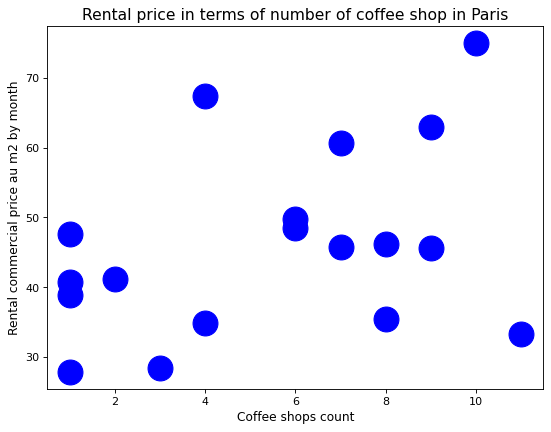

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(merged_innerr["Coffee shop"], merged_innerr["Average commercial rental price by m2"], c = 'blue', s=500)
plt.xlabel("Coffee shops count", fontsize=11)
plt.ylabel("Rental commercial price au m2 by month", fontsize=11)
plt.title("Rental price in terms of number of coffee shop in Paris", fontsize=14)

We can see that when the number of coffee shop is improves the rental commercial price is generally high or middle high and when there is a few number of coffee shops the rental price is generally low. So indeed we can say that there is a relationship between the two variables.

Now, let's get a geojson file to obtain the geographic informations of each borough in Paris in order to create a choropleth map which clearly disctinct each borough.

In [22]:
import json
geo = json.load(open("arrondissements.geojson"))

In [23]:
df_rentPrice['Postal Code'] = df_rentPrice['Postal Code'].astype(int)

Let's create the map and add markers which shows each coffee shop.

In [24]:
m = folium.Map(location=[latitude, longitude], zoom_start=12)
 
# Add the color for the chloropleth:
m.choropleth(
 geo_data=geo,
 name='choropleth',
 data=df_rentPrice,
 columns=['Postal Code', 'Average commercial rental price by m2'],
 key_on="feature.properties.c_arinsee",
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Rental price by month'
)
folium.LayerControl().add_to(m)

for i in range(0,len(merged_inner)):
    # add a red circle marker to represent the coffee shops
    folium.Marker(
        [merged_inner.iloc[i]['Coffee Latitude'], merged_inner.iloc[i]['Coffee Longitude']],
        popup='Coffee shop'
    ).add_to(m)

# display map
m

## 2. Analyze each borough

Let's create a function to get nearby venues to all boroughs in Paris

In [25]:
def getNearbyV(latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
            
        # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            radius, 
            LIMIT)
            
           # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
        # return only relevant information for each nearby venue
    for v in results:
        if 'postalCode' in v['venue']['location'] and 'city' in v['venue']['location']: 
            venues_list.append([(
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],
                    v['venue']['location']['postalCode'], 
                    v['venue']['location']['city'],
                    v['venue']['location']['address'],
                    v['venue']['categories'][0]['name']) for v in results])
            

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venues', 
                  'Venues Latitude', 
                  'Venues Longitude', 
                  'Venues Postal Code',
                  'Venues City',
                  'Venues Address',
                  'Venues Category']
    return(nearby_venues)

Now I run the above function to create a new dataframe called paris_venues.

In [26]:
paris_venues = getNearbyV(latitude, longitude, 5000, 200)

In [27]:
paris_venues

,Venues,Venues Latitude,Venues Longitude,Venues Postal Code,Venues City,Venues Address,Venues Category
0,Place de l'Hôtel de Ville – Esplanade de la Li...,48.856925,2.351412,75004,Paris,Place de l'Hôtel de Ville,Plaza
1,Fleux',48.858763,2.354161,75004,Paris,39 et 52 rue Sainte-Croix de la Bretonnerie,Furniture / Home Store
2,Cathédrale Notre-Dame de Paris,48.853124,2.349561,75004,Paris,6 parvis Notre-Dame,Church
3,Boutique du Centre Pompidou,48.860706,2.352362,75004,Paris,Place Georges Pompidou,Souvenir Shop
4,Comme à Lisbonne,48.856767,2.356462,75004,Paris,37 rue du Roi de Sicile,Café
...,...,...,...,...,...,...,...
9995,Galerie de Paléontologie et d'Anatomie comparée,48.843218,2.363336,75005,Paris,2 rue Buffon,Science Museum
9996,La Vache dans les Vignes,48.869725,2.366972,75010,Paris,46 quai de Jemmapes,Cheese Shop
9997,Grand Bassin Rond,48.862880,2.329295,75001,Paris,Jardin des Tuileries,Fountain
9998,Chambelland,48.864540,2.373300,75011,Paris,14 rue Ternaux,Bakery


I got a dataframe with 10000 rows and 7 columns. A huge number of rows !
Then, I counted the number of venues by borough to see the active boroughs and not active.

In [28]:
paris_venues.groupby('Venues Postal Code').count()

,Venues,Venues Latitude,Venues Longitude,Venues City,Venues Address,Venues Category
Venues Postal Code,,,,,,
75001,1400,1400,1400,1400,1400,1400
75002,700,700,700,700,700,700
75003,1100,1100,1100,1100,1100,1100
75004,1700,1700,1700,1700,1700,1700
75005,1100,1100,1100,1100,1100,1100
75006,1700,1700,1700,1700,1700,1700
75007,200,200,200,200,200,200
75009,100,100,100,100,100,100
75010,500,500,500,500,500,500


In [29]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venues Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Venues Postal Code'] = paris_venues['Venues Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Venues Postal Code,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bistro,...,Supermarket,Tapas Restaurant,Tattoo Parlor,Toy / Game Store,Trattoria/Osteria,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store
0,75004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,75004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,75004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,75004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [30]:
paris_grouped = paris_onehot.groupby('Venues Postal Code').mean().reset_index()
paris_grouped

,Venues Postal Code,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bistro,...,Supermarket,Tapas Restaurant,Tattoo Parlor,Toy / Game Store,Trattoria/Osteria,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store
0,75001,0.000000,0.142857,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429
1,75002,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000
2,75003,0.090909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000
3,75004,0.058824,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000
4,75005,0.000000,0.000000,0.0,0.000000,0.090909,0.000000,0.000000,0.000000,0.090909,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,75006,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.176471,0.000000
6,75007,0.500000,0.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,75009,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,75010,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
9,75011,0.000000,0.000000,0.0,0.071429,0.142857,0.071429,0.000000,0.000000,0.000000,...,0.000000,0.071429,0.071429,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000


Let's print each borough along with the top 5 of most common venues

In [31]:
num_top_venues = 5

for hood in paris_grouped['Venues Postal Code']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Venues Postal Code'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----75001----
           venue  freq
0          Plaza  0.21
1  Historic Site  0.14
2     Art Museum  0.14
3         Garden  0.07
4       Fountain  0.07


----75002----
                venue  freq
0               Hotel  0.29
1            Wine Bar  0.14
2            Beer Bar  0.14
3  Italian Restaurant  0.14
4               Plaza  0.14


----75003----
             venue  freq
0   Sandwich Place  0.18
1      Art Gallery  0.09
2     Cocktail Bar  0.09
3  Bubble Tea Shop  0.09
4      Supermarket  0.09


----75004----
                           venue  freq
0                          Plaza  0.12
1                    Art Gallery  0.06
2                         Church  0.06
3  Vegetarian / Vegan Restaurant  0.06
4                  Souvenir Shop  0.06


----75005----
                   venue  freq
0              Bookstore  0.09
1                 Bistro  0.09
2    Indie Movie Theater  0.09
3            Escape Room  0.09
4  Portuguese Restaurant  0.09


----75006----
                 venue  freq
0

Let's put that into a pandas dataframe. First, let's write a function to sort the venues in descending order.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each borough.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Venues Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['Venues Postal Code'] = paris_grouped['Venues Postal Code']

for ind in np.arange(paris_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

venues_sorted

,Venues Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75001,Plaza,Art Museum,Historic Site,Women's Store,Exhibit,Fountain,Pedestrian Plaza,Garden,Udon Restaurant,Toy / Game Store
1,75002,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
2,75003,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
3,75004,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
4,75005,Bistro,Science Museum,Portuguese Restaurant,Escape Room,Bakery,French Restaurant,Indie Movie Theater,Monument / Landmark,Bookstore,Botanical Garden
5,75006,Wine Bar,Plaza,Garden,Restaurant,French Restaurant,Electronics Store,Creperie,Ice Cream Shop,Cocktail Bar,Clothing Store
6,75007,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
7,75009,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
8,75010,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
9,75011,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria


## 3. Cluster Coffee shops 

Run k-means to cluster the coffee shops into 8 clusters.

In [34]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 8

paris_grouped_clustering = paris_grouped.drop('Venues Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 7, 6, 0, 5, 0, 2, 3, 4, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues where each coffee shops are located.

In [35]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = merged_inner

paris_merged = paris_merged.join(venues_sorted.set_index('Venues Postal Code'), on='Postal Code')

paris_merged.head() # check the last columns!

,Coffee shop,Coffee Latitude,Coffee Longitude,Postal Code,City,Address,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Laïzé 來座 (Laïzé),48.863077,2.355073,75003,Paris,19 rue de Montmorency,45.583333,6.0,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
1,Partisan,48.864754,2.353069,75003,Paris,36 rue de Turbigo,45.583333,6.0,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
2,Terres de Café,48.860580,2.355482,75003,Paris,14 rue Rambuteau,45.583333,6.0,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
3,Lily of the Valley,48.865221,2.361990,75003,Paris,12 rue Dupetit-Thouars,45.583333,6.0,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
4,Fringe,48.862612,2.364752,75003,Paris,106 rue de Turenne,45.583333,6.0,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant


In [36]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

I drop NAN values in the dataframe because there is many informations and we have to drop the null informations because it's not interesting for this analysis. 

In [37]:
paris_merged = paris_merged.dropna()

Let's visualize the resulting clusters with the map that clearly shows disctinct boroughs

In [47]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

paris_merged['Cluster Labels'] =paris_merged['Cluster Labels'].astype(int)
map_clusters.choropleth(
 geo_data=geo,
 name='choropleth',
 data=df_rentPrice,
 columns=['Postal Code', 'Average commercial rental price by m2'],
 key_on="feature.properties.c_arinsee",
 fill_color='YlOrRd',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Rent price by month'
)
folium.LayerControl().add_to(m)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Coffee Latitude'], paris_merged['Coffee Longitude'], paris_merged['Postal Code'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Examine Clusters

Now, I can examine each cluster and determine the features that distinguish each cluster. You can find my examination of each cluster in the report about this study.

Cluster 0

In [39]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
10,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
11,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
12,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
13,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
14,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
15,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
16,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
17,75004,62.916667,0,Plaza,Seafood Restaurant,Furniture / Home Store,Gourmet Shop,Hotel,Ice Cream Shop,Cocktail Bar,Israeli Restaurant,Church,Café
75,75006,67.333333,0,Wine Bar,Plaza,Garden,Restaurant,French Restaurant,Electronics Store,Creperie,Ice Cream Shop,Cocktail Bar,Clothing Store


In [40]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Cluster 2

In [41]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
70,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
71,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
72,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
73,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie
74,75007,48.5,2,Art Gallery,Art Museum,Cheese Shop,French Restaurant,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie


Cluster 3

In [42]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
53,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
54,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
55,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
56,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
57,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop
58,75009,45.833333,3,Indie Movie Theater,Women's Store,Cheese Shop,Fountain,Farmers Market,Exhibit,Escape Room,Electronics Store,Creperie,Comic Shop


Cluster 4

In [43]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
27,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
28,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
29,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
30,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
31,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
32,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
33,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
34,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room
35,75010,33.333333,4,Cheese Shop,Vegetarian / Vegan Restaurant,Hotel,Cocktail Bar,Breakfast Spot,Women's Store,Fountain,Farmers Market,Exhibit,Escape Room


Cluster 5

In [44]:
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
19,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
20,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
21,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
22,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
23,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
24,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
25,75011,35.50,5,Italian Restaurant,Bakery,Tattoo Parlor,Coffee Shop,Bookstore,Bar,Tapas Restaurant,French Restaurant,BBQ Joint,Trattoria/Osteria
37,75005,46.25,5,Bistro,Science Museum,Portuguese Restaurant,Escape Room,Bakery,French Restaurant,Indie Movie Theater,Monument / Landmark,Bookstore,Botanical Garden
38,75005,46.25,5,Bistro,Science Museum,Portuguese Restaurant,Escape Room,Bakery,French Restaurant,Indie Movie Theater,Monument / Landmark,Bookstore,Botanical Garden


Cluster 6

In [45]:
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
1,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
2,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
3,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
4,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
5,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
6,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
7,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant
8,75003,45.583333,6,Sandwich Place,Art Gallery,Coffee Shop,Bubble Tea Shop,Cocktail Bar,Bookstore,Supermarket,Farmers Market,Wine Bar,Vietnamese Restaurant


Cluster 7

In [46]:
paris_merged.loc[paris_merged['Cluster Labels'] == 7, paris_merged.columns[[3] + list(range(6, paris_merged.shape[1]))]]

,Postal Code,Average commercial rental price by m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
47,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
48,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
49,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
50,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
51,75002,49.75,7,Hotel,Wine Bar,Historic Site,Beer Bar,Italian Restaurant,Plaza,Women's Store,Church,Exhibit,Escape Room
